# Fitting Fourier Series with symfit

In [80]:
from symfit import parameters, variables, sin, cos, Fit
import numpy as np
import matplotlib.pyplot as plt

def fourier_series(x, f, n=0):
    """
    Returns a symbolic fourier series of order `n`.
    
    Example from https://symfit.readthedocs.io/en/stable/examples/ex_fourier_series.html.

    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """
    f=1/(2*np.pi)
    # Make the parameter objects for all the terms
    a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))
    # Construct the series
    series = a0 + sum(ai * cos(i * f * x) + bi * sin(i * f * x)
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))

    return series

def fit_fourier(input_vals, targets, complete_input_vals, fundamental_freq, order=10):
    
    """
    Fit a Fourier series to the a set of input and output values.
    
    complete_input_vals is used to impute missing values.
    """
    
    # Define symbolic model with inputs x and targets y.
    x, y = variables('x, y')
    # Define model parameters w.
    w, = parameters('w')
    model_dict = {y: fourier_series(x, f=w, n=order)}

    # Define a Fit object for this model and data.
    fit = Fit(model_dict, x=input_vals, y=targets)
    fit_result = fit.execute()
    
    # Impute missing values.
    fitted_fourier = fit.model(x=complete_input_vals, **fit_result.params).y
    
    return fitted_fourier, fit_result, fit

def optimise_fourier(input_vals, targets, complete_input_vals, fundamental_freq, orders=[3,4,5,6,7]):
    
    """
    Fit a Fourier series to the a set of input and output values.
    
    complete_input_vals is used to impute missing values.
    """
    
    best_order = 0
    best_aic = 1000
    
    for order in orders:
    
        fitted_vals, fit_result, fit = fit_fourier(input_vals, targets, input_vals, fundamental_freq, order=order)
        fitted_fourier = fit.model(x=complete_input_vals, **fit_result.params).y
        max_diff = np.max(fitted_fourier) - np.max(targets)
        se = np.square(fitted_vals-targets)
        aic_score = get_AIC(2*order + 1, se, max_diff)
        
        if aic_score < best_aic:
            best_order = order
            best_aic = aic_score
        
    fitted_vals, fit_result, fit = fit_fourier(input_vals, targets, complete_input_vals, fundamental_freq, order=best_order)
    
    # Impute missing values.
    fitted_fourier = fit.model(x=complete_input_vals, **fit_result.params).y
    
    return fitted_fourier

def get_AIC(free_params, se, max_diff):
    
    """
    Akaike Information Criterion (AIC).
    """
    
    return .1*free_params + 5*np.mean(se) + 2*np.abs(max_diff)

In [81]:
# Choose order of Fourier series.
FOURIER_ORDER = 7

# Define symbolic model with inputs x and targets y.
x, y = variables('x, y')
# Define model parameters w.
w, = parameters('w')
model_dict = {y: fourier_series(x, f=w, n=FOURIER_ORDER)}
print(model_dict)

{y: a0 + a1*cos(0.159154943091895*x) + a2*cos(0.318309886183791*x) + a3*cos(0.477464829275686*x) + a4*cos(0.636619772367581*x) + a5*cos(0.795774715459477*x) + a6*cos(0.954929658551372*x) + a7*cos(1.11408460164327*x) + b1*sin(0.159154943091895*x) + b2*sin(0.318309886183791*x) + b3*sin(0.477464829275686*x) + b4*sin(0.636619772367581*x) + b5*sin(0.795774715459477*x) + b6*sin(0.954929658551372*x) + b7*sin(1.11408460164327*x)}


In [82]:
# Make step function data
xdata = np.concatenate([np.random.uniform(-np.pi, 3*np.pi, 100), np.random.uniform(4*np.pi, 5*np.pi, 100)])

ydata = (np.sin(xdata) + np.random.normal(0,0.5,len(xdata)))*(xdata-np.min(xdata))/((np.max(xdata)-np.min(xdata)))

# Define a Fit object for this model and data
fit = Fit(model_dict, x=xdata, y=ydata)
fit_result = fit.execute()
print(fit_result)


Parameter Value        Standard Deviation
a0        1.969857e+03 1.658897e+03
a1        -1.997297e+03 1.606796e+03
a2        -1.027410e+03 1.022293e+03
a3        1.626648e+03 1.390067e+03
a4        -5.807888e+02 4.340740e+02
a5        -4.939639e+01 1.105043e+02
a6        6.696878e+01 6.234118e+01
a7        -8.543810e+00 6.303889e+00
b1        -2.982684e+03 2.564936e+03
b2        2.501271e+03 2.047464e+03
b3        -3.357936e+02 2.668933e+02
b4        -5.634427e+02 5.463168e+02
b5        2.929500e+02 2.366780e+02
b6        -3.171469e+01 2.546891e+01
b7        -4.507880e+00 6.726721e+00
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   109
Objective              <symfit.core.objectives.LeastSquares object at 0x7f795fbafc50>
Minimizer              <symfit.core.minimizers.BFGS object at 0x7f795fbaff60>

Goodness of fit qualifiers:
chi_squared            17.06925912565861
objective_value        8.534629562829306
r_squared           

In [83]:
# Get input values over entire domain.
input_data = np.linspace(-np.pi, 5*np.pi, 200)

# Now plot the fitted Fourier series over input_data.
fitted_fourier = fit.model(x=input_data, **fit_result.params).y

# Compare to true values over entire domain (without noise).
ytrue = (np.sin(input_data))*(input_data-np.min(xdata))/((np.max(xdata)-np.min(xdata)))

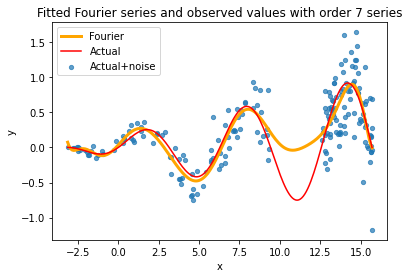

In [84]:
# Plot the result
plt.scatter(xdata, ydata, label="Actual+noise", s = 18, alpha=0.7)
#plt.scatter(xdata, fit.model(x=xdata, **fit_result.params).y, ls=':', label="Fourier")
plt.plot(input_data, fitted_fourier, label="Fourier", color='orange', linewidth=3)
plt.plot(input_data, ytrue, label="Actual", color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title("Fitted Fourier series and observed values with order {} series".format(FOURIER_ORDER))
plt.show()